In [24]:
# Imports: General tools
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle

from matplotlib import cm
from functools import partial
import pyDOE
from sklearn.gaussian_process.kernels import Matern
import cma

# Imports: robustGP
from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d
import robustGP.tools as tools
import robustGP.gptools
import robustGP.acquisition.acquisition as ac
import robustGP.enrichment.Enrichment as enrich
import robustGP.optimisers as opt
from scipy.stats import qmc

from adaptive_article import initialize_branin, fname, callback

# # Plotting options
# plt.style.use("seaborn")
# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "sans-serif",
#         "font.serif": ["Computer Modern Roman"],
#         "image.cmap": "viridis",
#         "figure.figsize": [5.748031686730317, 3.552478950810724],
#         "savefig.dpi": 400,
#     }
# )
# plt.rc("text.latex", preamble=r"\usepackage{amsmath} \usepackage{amssymb}")
# graphics_folder = "/home/victor/collab_article/adaptive/figures/"
# graphics_folder = "./figures/"

bounds = np.asarray([[0, 1], [0, 1]])
# For plots
x, y = np.linspace(0, 1, 2**3), np.linspace(0, 1, 2**3)
(XY, (xmg, ymg)) = tools.pairify((x, y))
xl, yl = np.linspace(0, 1, 2**6), np.linspace(0, 1, 2**6)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))
Niter = 100

In [25]:
def callback(arg, i, filename):
    if i % 5 == 0:
        mdel, sdel = arg.predict_GPdelta(XY, alpha=2)
        n_added_points = len(arg.gp.X_train_) - 10
        m, s = arg.predict(XY, return_std=True)
        npts = int(np.sqrt(len(XY)))

    # plt.figure(figsize=(8, 6))
    # plt.subplot(2, 2, 1)
    # plt.contourf(xmg, ymg, m.reshape(npts, npts))
    # plt.plot(arg.gp.X_train_[:10, 0], arg.gp.X_train_[:10, 1], ".w")
    # plt.plot(arg.gp.X_train_[10:, 0], arg.gp.X_train_[10:, 1], ".r")
    # plt.title(r"$m_Z$")

    # plt.subplot(2, 2, 3)
    # plt.contourf(xmg, ymg, s.reshape(npts, npts))
    # plt.plot(arg.gp.X_train_[:10, 0], arg.gp.X_train_[:10, 1], ".w")
    # plt.plot(arg.gp.X_train_[10:, 0], arg.gp.X_train_[10:, 1], ".r")
    # plt.title(r"$\sigma_{Z}$")

    # plt.subplot(2, 2, 2)
    # plt.contourf(xmg, ymg, mdel.reshape(npts, npts))
    # plt.plot(arg.gp.X_train_[:10, 0], arg.gp.X_train_[:10, 1], ".w")
    # plt.plot(arg.gp.X_train_[10:, 0], arg.gp.X_train_[10:, 1], ".r")
    # plt.title(r"$m_{\Delta}$")

    # plt.subplot(2, 2, 4)
    # plt.contourf(xmg, ymg, sdel.reshape(npts, npts))
    # plt.plot(arg.gp.X_train_[:10, 0], arg.gp.X_train_[:10, 1], ".w")
    # plt.plot(arg.gp.X_train_[10:, 0], arg.gp.X_train_[10:, 1], ".r")
    # plt.title(r"$\sigma_{\Delta}$")

    # if isinstance(filename, str):
    #     fname = filename
    # elif filename is None:
    #     fname = f"{graphics_folder}maxvar_{n_added_points}.png"
    # else:
    #     fname = filename(n_added_points)
    # plt.tight_layout()
    # plt.savefig(fname)
    # plt.close()
        return (np.sum(s**2), np.sum(sdel**2))
    else: 
        return np.nan, np.nan

In [26]:
## Sobol sequence
sobol_sampler = qmc.Sobol(d=2)
initial_design = sobol_sampler.random_base2(m=3)
branin_sobol = initialize_branin(initial_design=initial_design)

In [27]:
## Halton sequence

halton_sampler = qmc.Halton(d=2)
initial_design = halton_sampler.random(n=8)
branin_halton = initialize_branin(initial_design=initial_design)


class HaltonEnrich(enrich.InfillEnrichment):
    def __init__(self, bounds, sampler):
        super(HaltonEnrich, self).__init__(bounds)
        self.sampler = sampler

    def run(self, gp):
        return np.atleast_2d(self.sampler.random(n=1)), "Halton"


halton_enrich = HaltonEnrich(bounds, halton_sampler)
branin_halton.set_enrichment(halton_enrich)


run_diag = branin_halton.run(
    Niter=Niter, callback=partial(callback, filename=fname("Halton"))
)
imse_halton, imse_del_halton = list(zip(*run_diag))
halton_dict = {
    "model": branin_halton,
    "logs": {"imse": imse_halton, "imse_del": imse_del_halton},
}
result_dictionary = {"halton": halton_dict}

## Monte Carlo



 74%|███████▍  | 74/100 [02:24<01:09,  2.66s/it]/home/vtrappler/robustGP/.venvrobustGP/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 82%|████████▏ | 82/100 [02:54<01:01,  3.44s/it]/home/vtrappler/robustGP/.venvrobustGP/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 94%|█████████▍| 94/100 [03:27<00:15,  2.53s/it]/home/vtrappler/robustGP/.venvrobustGP/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:61

In [28]:
initial_design = scipy.stats.uniform.rvs(size=(10, 2))
for i in range(10):
    branin_MC = initialize_branin(initial_design=initial_design)
    montecarlo_enrich = enrich.MonteCarloEnrich(dim=2, bounds=bounds, sampler=None)
    branin_MC.set_enrichment(montecarlo_enrich)

    run_diag = branin_MC.run(Niter=Niter, callback=partial(callback, filename=fname("MC")))
    imse_MC, imse_del_MC = list(zip(*run_diag))
    MC_dict = {
        "model": branin_MC,
        "logs": {"imse": imse_MC, "imse_del": imse_del_MC},
    }
    result_dictionary[f"MC_{i}"] = MC_dict


 89%|████████▉ | 89/100 [04:40<00:41,  3.81s/it]/home/vtrappler/robustGP/.venvrobustGP/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 39%|███▉      | 39/100 [00:46<01:06,  1.08s/it]/home/vtrappler/robustGP/.venvrobustGP/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 39%|███▉      | 39/100 [01:26<03:19,  3.27s/it]/home/vtrappler/robustGP/.venvrobustGP/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:61

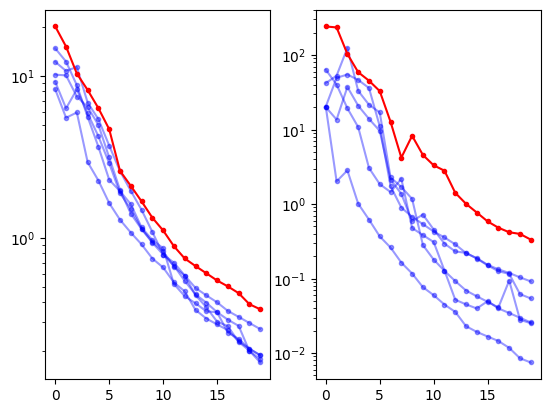

In [29]:
%matplotlib inline
fig, axs = plt.subplots(ncols=2)
for i in range(5):
    imse = np.array(result_dictionary[f"MC_{i}"]["logs"]["imse"])
    imse = imse[~np.isnan(imse)]
    imse_del = np.array(result_dictionary[f"MC_{i}"]["logs"]["imse_del"])
    imse_del = imse_del[~np.isnan(imse_del)]
    axs[0].plot(imse, '.-', label="imse", color="b", alpha=0.4)
    axs[1].plot(imse_del, '.-', label="imse del", color="b", alpha=0.4)
imse = np.array(result_dictionary["halton"]["logs"]["imse"])
imse = imse[~np.isnan(imse)]
imse_del = np.array(result_dictionary["halton"]["logs"]["imse_del"])
imse_del = imse_del[~np.isnan(imse_del)]
axs[0].plot(imse, '.-', color="r")
axs[1].plot(imse_del, '.-', color="r")
for ax in axs:
    ax.set_yscale("log")
plt.show()

array([246.25886168, 101.04970802,  85.98290347,  58.44202482])

In [12]:
imse

(16.703748575911614,
 nan,
 nan,
 nan,
 nan,
 11.80048426956243,
 nan,
 nan,
 nan,
 nan,
 7.212259314239949,
 nan,
 nan,
 nan,
 nan,
 5.08057392395181,
 nan,
 nan,
 nan,
 nan)

In [30]:


## Maximum of Variance
branin_maxvar = initialize_branin()
opts = cma.CMAOptions()
opts["bounds"] = list(zip(*bounds))
opts["maxfevals"] = 50
opts["verbose"] = -5
maximum_variance = enrich.OneStepEnrichment(bounds)
maximum_variance.set_optim(
    cma.fmin2, **{"x0": np.array([0.5, 0.5]), "sigma0": 0.3, "options": opts}
)


def variance(arg, X):
    return arg.predict(X, return_std=True)[1] ** 2


maximum_variance.set_criterion(variance, maxi=True)
branin_maxvar.set_enrichment(maximum_variance)
run_diag = branin_maxvar.run(
    Niter=50, callback=partial(callback, filename=fname("variance"))
)
imse_maxvar, imse_del_maxvar = list(zip(*run_diag))
maxvar_dict = {
    "model": branin_maxvar,
    "logs": {"imse": imse_maxvar, "imse_del": imse_del_maxvar},
}
result_dictionary["maxvar"] = maxvar_dict


## augmented IMSE


def aIMSE_experiment(Niter, filename):
    branin_aIMSE = initialize_branin()
    opts = cma.CMAOptions()
    opts["bounds"] = list(zip(*bounds))
    opts["maxfevals"] = 50
    opts["verbose"] = -5
    aIMSE = enrich.OneStepEnrichment(bounds)
    aIMSE.set_optim(
        cma.fmin2, **{"x0": np.array([0.5, 0.5]), "sigma0": 0.3, "options": opts}
    )

    def augmented_IMSE(arg, X, scenarios, integration_points):
        if callable(integration_points):
            int_points = integration_points()
        else:
            int_points = integration_points

        def function_(arg):
            m, sd = arg.predict(int_points, return_std=True)
            return sd**2

        return ac.augmented_design(arg, X, scenarios, function_, {})

    integration_points = pyDOE.lhs(2, 50, criterion="maximin", iterations=50)
    aIMSE.set_criterion(
        augmented_IMSE,
        maxi=False,
        scenarios=None,
        integration_points=lambda: pyDOE.lhs(2, 50, criterion="maximin", iterations=50),
    )  #
    branin_aIMSE.set_enrichment(aIMSE)
    run_diag = branin_aIMSE.run(
        Niter=50, callback=partial(callback, filename=fname("aIMSE_50"))
    )
    imse_aIMSE, imse_del_aIMSE = list(zip(*run_diag))


## augmented IMSE delta
branin_aIMSE_delta = initialize_branin()
opts = cma.CMAOptions()
opts["bounds"] = list(zip(*bounds))
opts["maxfevals"] = 50
opts["verbose"] = -9
aIMSE_delta = enrich.OneStepEnrichment(bounds)
aIMSE_delta.set_optim(
    cma.fmin2, **{"x0": np.array([0.5, 0.5]), "sigma0": 0.3, "options": opts}
)


def augmented_IMSE_Delta(arg, X, scenarios, integration_points, alpha, beta=0):
    if callable(integration_points):
        int_points = integration_points()
    else:
        int_points = integration_points

    def function_(arg):
        m, va = arg.predict_GPdelta(int_points, alpha=alpha, beta=beta)
        return va

    return ac.augmented_design(arg, X, scenarios, function_, {})


aIMSE_delta.set_criterion(
    augmented_IMSE_Delta,
    maxi=False,
    scenarios=None,
    integration_points=lambda: pyDOE.lhs(2, 50, criterion="maximin", iterations=50),
    alpha=2.0,
    beta=0.0,
)  #

branin_aIMSE_delta.set_enrichment(aIMSE_delta)
run_diag = branin_aIMSE_delta.run(
    Niter=20, callback=partial(callback, filename=fname("aIMSE_delta"))
)
imse_aIMSE_delta, imse_del_aIMSE_delta = list(zip(*run_diag))
aIMSE_delta_dict = {
    "model": branin_aIMSE_delta,
    "logs": {"imse": imse_aIMSE_delta, "imse_del": imse_del_aIMSE_delta},
}


result_dictionary["aIMSE_delta"] = aIMSE_delta_dict


# plt.subplot(1, 2, 1)
# plt.plot(imse_MC, label="MC")
# plt.plot(imse_halton, label="Halton")
# plt.plot(imse_maxvar, label="maxvar")
# plt.plot(imse_aIMSE, label="aIMSE")
# plt.title(r"$\text{IMSE}_Z$")
# plt.yscale("log")

# plt.subplot(1, 2, 2)
# plt.plot(imse_del_MC, label="MC")
# plt.plot(imse_del_halton, label="Halton")
# plt.plot(imse_del_maxvar, label="maxvar")
# plt.plot(imse_del_aIMSE, label="aIMSE")
# plt.yscale("log")
# plt.title(r"$\text{IMSE}_{\Delta}$")
# plt.legend()
# plt.show()

# import pickle


# def save_gp_diag(sur_obj, diag, filename):
#     to_save_dict = {"AdaptiveStrat": sur_obj.gp, "diag": diag}
#     with open(filename, "wb") as open_file:
#         pickle.dump(to_save_dict, open_file)


aIMSE_diags = {"imse": imse_aIMSE, "imse_delta": imse_del_aIMSE}

save_gp_diag(branin_aIMSE, aIMSE_diags, "aIMSE.pkl")

with open("aIMSE.pkl", "rb") as open_file:
    gp_ = pickle.load(open_file)


  0%|          | 0/50 [00:00<?, ?it/s]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.861622074223981e-01 1.0e+00 2.93e-01  3e-01  3e-01 0:00.0
    2     12 -2.455886969171286e-01 1.4e+00 2.46e-01  2e-01  3e-01 0:00.1
    3     18 -3.034061189907559e-01 1.8e+00 2.09e-01  2e-01  2e-01 0:00.1
    9     54 -7.087477885343723e-01 3.1e+00 2.39e-01  1e-01  2e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:12:19 2022)
final/bestever f-value = -7.197670e-01 -7.197670e-01
incumbent solution: [0.976331275194659, 0.9986323525369754]
std deviation: [0.14707085778511875, 0.17499420421338946]


  2%|▏         | 1/50 [00:10<08:39, 10.60s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.521427322079449e-01 1.0e+00 2.77e-01  2e-01  3e-01 0:00.0
    2     12 -1.339343711592628e-01 1.3e+00 3.17e-01  3e-01  3e-01 0:00.0
    3     18 -2.746023815937762e-01 1.5e+00 3.84e-01  4e-01  4e-01 0:00.1
    9     54 -1.129409061161508e-01 3.0e+00 1.62e+00  2e+00  3e+00 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:12:30 2022)
final/bestever f-value = -5.589997e-02 -2.746024e-01
incumbent solution: [0.4934191382708848, 0.9713748643713997]
std deviation: [2.6618008892736147, 1.9691017333338738]


  4%|▍         | 2/50 [00:12<04:36,  5.76s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.632865953476286e-01 1.0e+00 2.69e-01  2e-01  3e-01 0:00.0
    2     12 -3.906922416725404e-01 1.2e+00 2.06e-01  1e-01  2e-01 0:00.0
    3     18 -4.768376256649717e-01 1.5e+00 2.44e-01  2e-01  2e-01 0:00.0
    9     54 -4.567264125666785e-01 1.8e+00 1.52e-01  8e-02  8e-02 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:12:32 2022)
final/bestever f-value = -4.533535e-01 -4.768376e-01
incumbent solution: [0.4041317236696146, 0.27320616670821246]
std deviation: [0.08367464338485849, 0.08491512803751902]


  6%|▌         | 3/50 [00:15<03:17,  4.21s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.406917739862858e-01 1.0e+00 3.36e-01  4e-01  4e-01 0:00.0
    2     12 -2.599061587678111e-01 1.2e+00 2.64e-01  2e-01  3e-01 0:00.0
    3     18 -2.612598149410343e-01 1.2e+00 2.30e-01  2e-01  2e-01 0:00.1
    9     54 -4.583255481102986e-01 2.8e+00 1.27e-01  5e-02  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:12:35 2022)
final/bestever f-value = -4.542567e-01 -4.583255e-01
incumbent solution: [0.7186932394061352, 0.9998316895288654]
std deviation: [0.05295329065155176, 0.12414630940496818]


  8%|▊         | 4/50 [00:18<03:02,  3.98s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.633152708856013e-01 1.0e+00 3.59e-01  4e-01  4e-01 0:00.1
    2     12 -4.138680922070688e-01 1.7e+00 3.04e-01  3e-01  3e-01 0:00.1
    3     18 -1.931240098893567e-01 1.6e+00 2.54e-01  2e-01  2e-01 0:00.1
    9     54 -2.726821964490667e-01 2.1e+00 1.57e-01  7e-02  1e-01 0:00.2


termination on maxfevals=50 (Tue Nov 15 17:12:39 2022)
final/bestever f-value = -2.670868e-01 -4.633153e-01
incumbent solution: [0.24790866774042725, 0.5379667445523256]
std deviation: [0.11864491484250296, 0.0688271963342139]


 10%|█         | 5/50 [00:22<02:57,  3.95s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.867872562856412e-01 1.0e+00 2.94e-01  3e-01  3e-01 0:00.0
    2     12 -2.180299841141413e-01 1.2e+00 2.81e-01  2e-01  3e-01 0:00.0
    3     18 -2.106472491088555e-01 1.5e+00 2.23e-01  2e-01  2e-01 0:00.1
    9     54 -2.490007124119178e-01 2.1e+00 1.86e-01  1e-01  2e-01 0:00.2



Evaluate and add point to design: : 1it [00:01,  1.36s/it]

termination on maxfevals=50 (Tue Nov 15 17:12:43 2022)
final/bestever f-value = -2.508975e-01 -2.727840e-01
incumbent solution: [0.24586371545667252, 0.588692015999082]
std deviation: [0.17176359810620906, 0.09969095997303462]


 12%|█▏        | 6/50 [00:37<05:34,  7.60s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.295470035509718e-01 1.0e+00 3.23e-01  3e-01  4e-01 0:00.0
    2     12 -2.342709134936329e-01 1.3e+00 3.59e-01  4e-01  4e-01 0:00.0
    3     18 -1.762745043405479e-01 1.2e+00 2.83e-01  3e-01  3e-01 0:00.0
    9     54 -1.652750343625944e-01 2.6e+00 2.79e-01  2e-01  3e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:12:57 2022)
final/bestever f-value = -2.400511e-01 -3.295470e-01
incumbent solution: [0.9502094671745644, 0.7210598869352918]
std deviation: [0.3383775710197579, 0.1667227426958229]


 14%|█▍        | 7/50 [00:41<04:40,  6.53s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.869232411885486e-01 1.0e+00 2.21e-01  2e-01  2e-01 0:00.0
    2     12 -2.424406906036062e-01 1.2e+00 2.81e-01  2e-01  4e-01 0:00.0
    3     18 -1.922523416057786e-01 1.9e+00 2.22e-01  1e-01  3e-01 0:00.1
    9     54 -2.360855616791878e-01 5.7e+00 1.47e-01  7e-02  2e-01 0:00.4


termination on maxfevals=50 (Tue Nov 15 17:13:04 2022)
final/bestever f-value = -2.264429e-01 -2.424407e-01
incumbent solution: [0.5628686313497426, 0.4787164720469896]
std deviation: [0.07063379917939352, 0.22956723743187113]


 16%|█▌        | 8/50 [00:50<04:56,  7.06s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.960417187064242e-01 1.0e+00 2.85e-01  2e-01  3e-01 0:00.1
    2     12 -1.731989587088712e-01 1.3e+00 5.18e-01  4e-01  7e-01 0:00.2
    3     18 -1.310152330678420e-01 1.8e+00 5.70e-01  4e-01  6e-01 0:00.2
    9     54 -2.361378446115205e-01 1.9e+00 2.98e-01  1e-01  3e-01 0:00.3


termination on maxfevals=50 (Tue Nov 15 17:13:11 2022)
final/bestever f-value = -1.284366e-01 -2.724573e-01
incumbent solution: [0.8818720437947671, 0.6915089341030862]
std deviation: [0.2527223494020913, 0.12990697675909976]


 18%|█▊        | 9/50 [00:55<04:33,  6.67s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.260480805122014e-01 1.0e+00 2.62e-01  2e-01  3e-01 0:00.0
    2     12 -2.028136983067672e-01 1.1e+00 2.01e-01  2e-01  2e-01 0:00.1
    3     18 -1.329971856266998e-01 1.1e+00 1.84e-01  1e-01  1e-01 0:00.1
    9     54 -2.257006979770894e-01 1.2e+00 5.96e-02  2e-02  3e-02 0:00.2



Evaluate and add point to design: : 1it [00:01,  1.52s/it]

termination on maxfevals=50 (Tue Nov 15 17:13:16 2022)
final/bestever f-value = -2.241265e-01 -2.260481e-01
incumbent solution: [0.6011524539843889, 0.510820596774249]
std deviation: [0.021393405144775973, 0.027628036611247665]


 20%|██        | 10/50 [00:59<03:55,  5.88s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -9.903897151912866e-02 1.0e+00 2.82e-01  2e-01  3e-01 0:00.0
    2     12 -6.356123530411539e-02 1.1e+00 2.39e-01  2e-01  2e-01 0:00.0
    3     18 -9.979167759220807e-02 1.0e+00 1.81e-01  1e-01  1e-01 0:00.1
    9     54 -1.243449408798994e-01 3.1e+00 2.63e-01  2e-01  2e-01 0:00.2


termination on maxfevals=50 (Tue Nov 15 17:13:21 2022)
final/bestever f-value = -5.822632e-02 -1.243449e-01
incumbent solution: [0.3943696960835246, 0.5677231221320433]
std deviation: [0.20383648783036096, 0.22152446203928425]


 22%|██▏       | 11/50 [01:17<06:07,  9.43s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -6.726875079013474e-02 1.0e+00 3.13e-01  3e-01  3e-01 0:00.2
    2     12 -8.276439760074085e-02 1.4e+00 4.22e-01  5e-01  5e-01 0:00.2
    3     18 -9.208846095981171e-02 1.1e+00 4.72e-01  5e-01  6e-01 0:00.3
    9     54 -1.135343802077232e-01 1.7e+00 1.86e-01  1e-01  1e-01 0:00.4


termination on maxfevals=50 (Tue Nov 15 17:13:38 2022)
final/bestever f-value = -8.865239e-02 -1.379006e-01
incumbent solution: [0.9989956841497329, 0.2243850574753547]
std deviation: [0.09638715085075306, 0.1400920251534759]


 24%|██▍       | 12/50 [01:23<05:17,  8.35s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -7.354698078179722e-02 1.0e+00 2.61e-01  2e-01  2e-01 0:00.1
    2     12 -8.413907231125607e-02 1.1e+00 2.53e-01  2e-01  2e-01 0:00.1
    3     18 -8.383696902058034e-02 1.2e+00 2.21e-01  2e-01  2e-01 0:00.1
    9     54 -1.373590686102250e-01 1.4e+00 2.04e-01  1e-01  1e-01 0:00.3


termination on maxfevals=50 (Tue Nov 15 17:13:43 2022)
final/bestever f-value = -1.152579e-01 -1.475501e-01
incumbent solution: [0.000657121235145856, 0.48529041380724525]
std deviation: [0.13613010635172784, 0.11454319241170946]


 26%|██▌       | 13/50 [01:27<04:19,  7.01s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -8.321742988083768e-02 1.0e+00 2.65e-01  2e-01  2e-01 0:00.0
    2     12 -8.844057630724798e-02 1.1e+00 3.75e-01  3e-01  5e-01 0:00.0
    3     18 -7.631757982847864e-02 1.7e+00 3.39e-01  3e-01  4e-01 0:00.0
    9     54 -8.579209054178716e-02 2.3e+00 7.78e-01  8e-01  1e+00 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:13:46 2022)
final/bestever f-value = -4.912403e-02 -1.457387e-01
incumbent solution: [0.25869034649398515, 0.9802766409855144]
std deviation: [1.458924137474178, 0.7790584117887611]


 28%|██▊       | 14/50 [01:29<03:19,  5.53s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -8.858134729993328e-02 1.0e+00 3.23e-01  3e-01  4e-01 0:00.0
    2     12 -5.396548995679430e-02 1.2e+00 2.34e-01  2e-01  2e-01 0:00.0
    3     18 -5.031620487872911e-02 1.2e+00 2.25e-01  2e-01  2e-01 0:00.0
    9     54 -9.332667031563659e-02 2.4e+00 2.88e-01  3e-01  4e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:13:49 2022)
final/bestever f-value = -1.227097e-02 -1.051599e-01
incumbent solution: [0.2994516934691328, 0.4715778294139358]
std deviation: [0.37245674248000255, 0.28963705404886936]


 30%|███       | 15/50 [01:31<02:33,  4.38s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.262272285955138e-02 1.0e+00 2.69e-01  2e-01  3e-01 0:00.0
    2     12 -7.097376868230042e-02 1.2e+00 2.64e-01  2e-01  3e-01 0:00.0
    3     18 -5.606635771902412e-02 1.5e+00 2.85e-01  2e-01  3e-01 0:00.1
    9     54 -8.482622812570860e-02 1.5e+00 9.61e-02  5e-02  5e-02 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:13:50 2022)
final/bestever f-value = -8.371942e-02 -8.482623e-02
incumbent solution: [0.5982389391837635, 0.2042441410865398]
std deviation: [0.0511415702882787, 0.05071170503019558]


 32%|███▏      | 16/50 [01:39<03:06,  5.50s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -6.869320192875061e-02 1.0e+00 2.95e-01  3e-01  3e-01 0:00.0
    2     12 -2.690512833189041e-02 1.3e+00 4.16e-01  4e-01  6e-01 0:00.0
    3     18 -8.222167534305436e-02 2.1e+00 4.40e-01  4e-01  6e-01 0:00.0
    9     54 -7.834085773904552e-02 2.5e+00 2.09e-01  1e-01  2e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:13:58 2022)
final/bestever f-value = -4.349394e-02 -9.199142e-02
incumbent solution: [0.5994969439703379, 0.8813451292727956]
std deviation: [0.17028223889830288, 0.11440919785216593]


 34%|███▍      | 17/50 [01:40<02:16,  4.13s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -6.204200124694325e-02 1.0e+00 2.24e-01  2e-01  2e-01 0:00.0
    2     12 -5.849733036612815e-02 1.3e+00 1.83e-01  1e-01  2e-01 0:00.0
    3     18 -7.121232880262775e-02 1.4e+00 1.49e-01  1e-01  1e-01 0:00.0
    9     54 -5.453005618824092e-02 2.3e+00 1.42e-01  7e-02  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:13:59 2022)
final/bestever f-value = -5.165430e-02 -7.121233e-02
incumbent solution: [0.37108327392574264, 0.5337452483405596]
std deviation: [0.13092285126462858, 0.06748226534992159]


 36%|███▌      | 18/50 [01:41<01:47,  3.37s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.132777870004988e-02 1.0e+00 3.27e-01  3e-01  4e-01 0:00.0
    2     12 -5.241556987817742e-02 1.5e+00 3.50e-01  3e-01  4e-01 0:00.0
    3     18 -7.055618428749245e-02 1.3e+00 5.18e-01  5e-01  5e-01 0:00.0
    9     54 -9.559353396980463e-02 1.2e+00 3.41e-01  2e-01  2e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:01 2022)
final/bestever f-value = -1.025106e-01 -1.025106e-01
incumbent solution: [0.005088060727257735, 0.27634774335066464]
std deviation: [0.20049304354328124, 0.21005765678068616]


 38%|███▊      | 19/50 [01:43<01:27,  2.82s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -5.136345245830597e-02 1.0e+00 2.83e-01  2e-01  3e-01 0:00.0
    2     12 -5.965453533089316e-02 1.2e+00 2.07e-01  2e-01  2e-01 0:00.0
    3     18 -5.979878441739150e-02 1.2e+00 4.40e-01  4e-01  5e-01 0:00.0
    9     54 -5.640116120979055e-02 1.3e+00 3.77e-01  3e-01  3e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:02 2022)
final/bestever f-value = -7.011433e-03 -6.019266e-02
incumbent solution: [0.02357557961048651, 0.02450041537794707]
std deviation: [0.2721571491935606, 0.25638942736956427]


 40%|████      | 20/50 [01:45<01:23,  2.79s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -5.126711727127153e-02 1.0e+00 3.43e-01  3e-01  4e-01 0:00.0
    2     12 -4.885488580047936e-02 1.4e+00 2.98e-01  2e-01  3e-01 0:00.0
    3     18 -3.323228934634915e-02 1.5e+00 2.54e-01  2e-01  3e-01 0:00.0
    9     54 -5.309637661164635e-02 2.5e+00 9.43e-02  3e-02  7e-02 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:05 2022)
final/bestever f-value = -5.350503e-02 -5.351576e-02
incumbent solution: [0.9146134519608686, 0.5144288313666354]
std deviation: [0.06699763272042837, 0.03269349816158822]


 42%|████▏     | 21/50 [01:54<02:14,  4.62s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.536984759777995e-02 1.0e+00 2.89e-01  3e-01  3e-01 0:00.0
    2     12 -6.094488291303479e-02 1.2e+00 3.00e-01  3e-01  3e-01 0:00.0
    3     18 -6.067941048388814e-02 1.3e+00 2.62e-01  2e-01  3e-01 0:00.0
    9     54 -6.345056273742333e-02 1.5e+00 8.94e-02  4e-02  5e-02 0:00.0



Acquisition: : 1it [00:00,  4.45it/s]

termination on maxfevals=50 (Tue Nov 15 17:14:14 2022)
final/bestever f-value = -6.316530e-02 -6.345056e-02
incumbent solution: [0.8717302835314878, 0.3196808040144276]
std deviation: [0.04144771154525757, 0.045065194736327446]


 44%|████▍     | 22/50 [01:56<01:45,  3.77s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.192653233358890e-02 1.0e+00 2.83e-01  3e-01  3e-01 0:00.0
    2     12 -4.234016377782734e-02 1.2e+00 2.47e-01  2e-01  2e-01 0:00.0
    3     18 -2.330370218181576e-02 1.3e+00 2.21e-01  2e-01  2e-01 0:00.0
    9     54 -6.593705907294557e-02 2.1e+00 1.62e-01  7e-02  2e-01 0:00.1



Evaluate and add point to design: : 1it [00:00,  2.86it/s]

termination on maxfevals=50 (Tue Nov 15 17:14:15 2022)
final/bestever f-value = -6.674885e-02 -6.674885e-02
incumbent solution: [0.5742970649321056, 0.997373625235678]
std deviation: [0.06894018672148948, 0.15900319160918613]


 46%|████▌     | 23/50 [01:57<01:21,  3.03s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.718058814560955e-02 1.0e+00 3.79e-01  3e-01  5e-01 0:00.0
    2     12 -3.635975821345261e-02 1.4e+00 5.43e-01  5e-01  8e-01 0:00.0
    3     18 -5.550198777552728e-02 1.6e+00 4.37e-01  4e-01  6e-01 0:00.0
    9     54 -4.674924636343925e-02 2.6e+00 1.90e-01  9e-02  2e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:17 2022)
final/bestever f-value = -3.429024e-02 -5.550199e-02
incumbent solution: [0.3793466449913803, 0.997276070757355]
std deviation: [0.08912751945310307, 0.23466952027249596]


 48%|████▊     | 24/50 [01:59<01:07,  2.58s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.282135017797638e-02 1.0e+00 2.38e-01  2e-01  2e-01 0:00.0
    2     12 -3.425064681142942e-02 1.1e+00 1.98e-01  2e-01  2e-01 0:00.0
    3     18 -2.793570343251284e-02 1.2e+00 1.86e-01  1e-01  1e-01 0:00.0
    9     54 -3.257738400103261e-02 1.7e+00 1.52e-01  9e-02  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:19 2022)
final/bestever f-value = -2.213835e-02 -3.425065e-02
incumbent solution: [0.6070552747522394, 0.6558892642163598]
std deviation: [0.12280211927004821, 0.08680414031792079]


 50%|█████     | 25/50 [02:02<01:06,  2.66s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.793737309556676e-02 1.0e+00 2.94e-01  3e-01  3e-01 0:00.0
    2     12 -3.711490384430727e-02 1.1e+00 3.35e-01  3e-01  4e-01 0:00.0
    3     18 -4.499296340191439e-02 1.5e+00 3.27e-01  3e-01  3e-01 0:00.0
    9     54 -4.664110199146843e-02 1.8e+00 1.76e-01  1e-01  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:21 2022)
final/bestever f-value = -4.427300e-02 -5.855500e-02
incumbent solution: [0.07336935727520029, 0.14004249258986287]
std deviation: [0.12226898657077136, 0.11971606063170072]


 52%|█████▏    | 26/50 [02:15<02:20,  5.86s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.034222825581279e-02 1.0e+00 3.47e-01  3e-01  4e-01 0:00.0
    2     12 -2.825941426973921e-02 1.4e+00 3.45e-01  3e-01  4e-01 0:00.0
    3     18 -2.453496080782025e-02 1.4e+00 4.14e-01  3e-01  6e-01 0:00.0
    9     54 -4.874368300844933e-02 2.8e+00 3.04e-01  2e-01  4e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:34 2022)
final/bestever f-value = -1.987802e-02 -4.874368e-02
incumbent solution: [0.25610167615269736, 0.9914932442456548]
std deviation: [0.3719937997921042, 0.2240636673809145]


 54%|█████▍    | 27/50 [02:17<01:49,  4.75s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.764794834717122e-02 1.0e+00 2.88e-01  3e-01  3e-01 0:00.0
    2     12 -3.764571779255409e-02 1.4e+00 3.53e-01  4e-01  4e-01 0:00.0
    3     18 -3.279138609658960e-02 1.8e+00 3.86e-01  4e-01  5e-01 0:00.0
    9     54 -2.864605538872111e-02 3.5e+00 5.75e-01  7e-01  9e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:36 2022)
final/bestever f-value = -1.740720e-02 -4.766055e-02
incumbent solution: [0.20134781205049768, 0.9464497901447941]
std deviation: [0.8998792142064387, 0.7122156261616241]


 56%|█████▌    | 28/50 [02:19<01:22,  3.73s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.201619659775922e-02 1.0e+00 2.74e-01  2e-01  3e-01 0:00.0
    2     12 -2.789261664231435e-02 1.2e+00 3.28e-01  3e-01  4e-01 0:00.0
    3     18 -2.743422560978359e-02 1.4e+00 3.38e-01  3e-01  4e-01 0:00.0
    9     54 -2.892953415996113e-02 1.4e+00 3.36e-01  3e-01  4e-01 0:00.0


termination on maxfevals=50 (Tue Nov 15 17:14:38 2022)
final/bestever f-value = -1.185067e-02 -3.201620e-02
incumbent solution: [0.00838595774017665, 0.6245031791740911]
std deviation: [0.3586506021788175, 0.27993037940125837]


 58%|█████▊    | 29/50 [02:20<01:04,  3.08s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.717556534872278e-02 1.0e+00 3.36e-01  3e-01  4e-01 0:00.0
    2     12 -2.549061655084195e-02 1.4e+00 3.08e-01  3e-01  3e-01 0:00.0
    3     18 -2.371456387235071e-02 1.4e+00 2.99e-01  3e-01  3e-01 0:00.0
    9     54 -3.210642141147602e-02 2.4e+00 2.71e-01  3e-01  3e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:40 2022)
final/bestever f-value = -2.160133e-02 -3.210642e-02
incumbent solution: [0.22772073657681058, 0.945006687497211]
std deviation: [0.2641028688731769, 0.258795569316515]


 60%|██████    | 30/50 [02:22<00:53,  2.69s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.567971340797948e-02 1.0e+00 2.28e-01  2e-01  2e-01 0:00.0
    2     12 -2.170072803808187e-02 1.1e+00 2.11e-01  2e-01  2e-01 0:00.0
    3     18 -2.731981107290626e-02 1.1e+00 1.47e-01  1e-01  1e-01 0:00.0
    9     54 -2.678171310153543e-02 1.7e+00 8.16e-02  3e-02  5e-02 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:41 2022)
final/bestever f-value = -2.661286e-02 -2.731981e-02
incumbent solution: [0.37133528205263244, 0.3692910110745074]
std deviation: [0.02954508758132714, 0.05078125552013993]


 62%|██████▏   | 31/50 [02:30<01:22,  4.32s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.223953794101431e-02 1.0e+00 2.99e-01  3e-01  3e-01 0:00.0
    2     12 -2.201152903265579e-02 1.2e+00 2.79e-01  2e-01  3e-01 0:00.0
    3     18 -1.885088844347527e-02 1.5e+00 2.18e-01  2e-01  3e-01 0:00.0
    9     54 -2.863892560883486e-02 1.7e+00 1.55e-01  7e-02  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:50 2022)
final/bestever f-value = -1.301188e-02 -3.223954e-02
incumbent solution: [0.23801157076368312, 0.6199724285612466]
std deviation: [0.14333919653536134, 0.07338997535482933]


 64%|██████▍   | 32/50 [02:33<01:07,  3.73s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.056154671955768e-02 1.0e+00 2.70e-01  2e-01  3e-01 0:00.0
    2     12 -2.090230515826053e-02 1.1e+00 3.00e-01  3e-01  3e-01 0:00.0
    3     18 -1.296665857599166e-02 1.4e+00 2.68e-01  2e-01  3e-01 0:00.0
    9     54 -3.643117857387156e-02 1.7e+00 4.84e-01  3e-01  5e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:52 2022)
final/bestever f-value = -3.063833e-02 -3.643118e-02
incumbent solution: [0.8558379647766254, 0.9518962396760913]
std deviation: [0.34875551428164286, 0.5151639251590647]


 66%|██████▌   | 33/50 [02:33<00:49,  2.88s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.500924351104649e-02 1.0e+00 2.56e-01  2e-01  2e-01 0:00.0
    2     12 -2.508245395988817e-02 1.0e+00 3.29e-01  3e-01  4e-01 0:00.0
    3     18 -1.921451394265516e-02 1.3e+00 4.03e-01  4e-01  5e-01 0:00.0
    9     54 -1.556786949014821e-02 2.6e+00 3.90e-01  3e-01  6e-01 0:00.0


termination on maxfevals=50 (Tue Nov 15 17:14:53 2022)
final/bestever f-value = -1.077551e-02 -2.747229e-02
incumbent solution: [0.7951309993451063, 0.9298066931946247]
std deviation: [0.5646887369181839, 0.326570013955268]


 68%|██████▊   | 34/50 [02:35<00:38,  2.43s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.056166592437747e-02 1.0e+00 3.76e-01  3e-01  5e-01 0:00.0
    2     12 -1.799048818517989e-02 1.6e+00 3.49e-01  3e-01  4e-01 0:00.0
    3     18 -1.213876883505738e-02 1.6e+00 3.70e-01  4e-01  4e-01 0:00.0
    9     54 -1.395430413210397e-02 1.9e+00 6.82e-01  6e-01  8e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:54 2022)
final/bestever f-value = -1.178506e-02 -2.383234e-02
incumbent solution: [0.4899675323987308, 0.7059228313015581]
std deviation: [0.6245967729525406, 0.757829340382218]


 70%|███████   | 35/50 [02:36<00:32,  2.20s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.414570673120652e-02 1.0e+00 2.73e-01  3e-01  3e-01 0:00.0
    2     12 -1.822363229742807e-02 1.2e+00 3.38e-01  4e-01  4e-01 0:00.0
    3     18 -2.301102886250683e-02 1.8e+00 3.61e-01  4e-01  4e-01 0:00.0
    9     54 -2.246490725168360e-02 3.1e+00 7.90e-01  8e-01  2e+00 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:14:56 2022)
final/bestever f-value = -4.734731e-03 -2.883952e-02
incumbent solution: [0.00036317708354269523, 0.6397963283281376]
std deviation: [0.8269989070320656, 1.506285747859585]


 72%|███████▏  | 36/50 [02:42<00:42,  3.06s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.049270013584946e-02 1.0e+00 2.52e-01  2e-01  2e-01 0:00.0
    2     12 -2.026030579062066e-02 1.1e+00 2.37e-01  2e-01  2e-01 0:00.0
    3     18 -2.461164316415210e-02 1.2e+00 3.39e-01  3e-01  4e-01 0:00.0
    9     54 -2.330902440576011e-02 2.5e+00 3.24e-01  2e-01  4e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:01 2022)
final/bestever f-value = -1.174454e-02 -2.461164e-02
incumbent solution: [0.9311550783591864, 0.656827139659552]
std deviation: [0.1675734868927531, 0.4156552799242432]


 74%|███████▍  | 37/50 [02:50<01:02,  4.77s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.938516521111289e-02 1.0e+00 3.56e-01  4e-01  4e-01 0:00.0
    2     12 -2.078811481944576e-02 1.3e+00 3.50e-01  3e-01  4e-01 0:00.0
    3     18 -1.927247442759428e-02 1.6e+00 3.80e-01  3e-01  4e-01 0:00.0
    9     54 -2.019233892924244e-02 1.8e+00 6.08e-01  5e-01  5e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:10 2022)
final/bestever f-value = -4.668385e-03 -2.543179e-02
incumbent solution: [0.9466024936256895, 0.6089257763565294]
std deviation: [0.5471015739346397, 0.5231076916100684]


 76%|███████▌  | 38/50 [02:52<00:46,  3.90s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.584795830334306e-02 1.0e+00 3.76e-01  4e-01  5e-01 0:00.0
    2     12 -5.552300759184670e-03 1.7e+00 4.22e-01  4e-01  5e-01 0:00.0
    3     18 -1.549197755271192e-02 1.3e+00 4.57e-01  5e-01  6e-01 0:00.1
    9     54 -1.821800453536749e-02 1.3e+00 5.07e-01  4e-01  5e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:12 2022)
final/bestever f-value = -1.451058e-03 -2.320729e-02
incumbent solution: [0.9338141461906965, 0.026932958143989588]
std deviation: [0.4285373002261977, 0.5303576445845838]


 78%|███████▊  | 39/50 [02:55<00:39,  3.58s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.381382718144353e-02 1.0e+00 2.27e-01  2e-01  2e-01 0:00.0
    2     12 -1.582566882571634e-02 1.1e+00 1.98e-01  2e-01  2e-01 0:00.0
    3     18 -1.329444371308730e-02 1.0e+00 2.27e-01  2e-01  2e-01 0:00.0
    9     54 -1.715451225855047e-02 1.3e+00 1.71e-01  1e-01  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:14 2022)
final/bestever f-value = -1.732225e-02 -1.917685e-02
incumbent solution: [0.9999762552006292, 0.5926067710552168]
std deviation: [0.10565903157671981, 0.09815019485491445]


 80%|████████  | 40/50 [02:57<00:30,  3.02s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -8.859695500486264e-03 1.0e+00 2.69e-01  2e-01  3e-01 0:00.0
    2     12 -1.406092238686851e-02 1.2e+00 3.27e-01  3e-01  4e-01 0:00.0
    3     18 -1.485894731930593e-02 1.4e+00 2.81e-01  2e-01  3e-01 0:00.0
    9     54 -1.730467706081229e-02 2.1e+00 2.84e-01  2e-01  4e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:16 2022)
final/bestever f-value = -2.012674e-02 -2.012674e-02
incumbent solution: [0.6804646923433035, 0.3359669654191587]
std deviation: [0.15000389254326002, 0.37079705090787]


 82%|████████▏ | 41/50 [03:17<01:13,  8.12s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.353105979472180e-02 1.0e+00 2.92e-01  3e-01  3e-01 0:00.0
    2     12 -1.668853615172561e-02 1.3e+00 2.74e-01  2e-01  3e-01 0:00.0
    3     18 -1.935248735837470e-02 1.4e+00 2.52e-01  2e-01  2e-01 0:00.1
    9     54 -2.197000562852613e-02 1.9e+00 2.17e-01  2e-01  2e-01 0:00.2


termination on maxfevals=50 (Tue Nov 15 17:15:37 2022)
final/bestever f-value = -6.523277e-03 -2.197001e-02
incumbent solution: [0.0016981795458585478, 0.20797513512319632]
std deviation: [0.1651961886771581, 0.17967580214473902]


 84%|████████▍ | 42/50 [03:20<00:53,  6.64s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -9.274250885232149e-03 1.0e+00 2.43e-01  2e-01  2e-01 0:00.0
    2     12 -1.569754640122645e-02 1.2e+00 2.33e-01  2e-01  2e-01 0:00.0
    3     18 -1.258455156945715e-02 1.3e+00 2.39e-01  2e-01  2e-01 0:00.1
    9     54 -1.005384774167173e-02 1.8e+00 1.07e-01  5e-02  6e-02 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:39 2022)
final/bestever f-value = -1.084456e-02 -1.569755e-02
incumbent solution: [0.1422343404682035, 0.2701966186086659]
std deviation: [0.061468007732314145, 0.051869685866130985]


 86%|████████▌ | 43/50 [03:28<00:50,  7.18s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.490092039960622e-02 1.0e+00 3.20e-01  3e-01  4e-01 0:00.0
    2     12 -7.811563392007947e-03 1.3e+00 3.08e-01  3e-01  3e-01 0:00.0
    3     18 -1.083784626914297e-02 1.4e+00 4.40e-01  4e-01  7e-01 0:00.0
    9     54 -1.439331335419269e-02 2.9e+00 1.71e-01  8e-02  2e-01 0:00.2


termination on maxfevals=50 (Tue Nov 15 17:15:48 2022)
final/bestever f-value = -6.265460e-03 -1.709176e-02
incumbent solution: [0.2925739054569768, 0.002288973724684082]
std deviation: [0.08399165317715655, 0.1974436778019223]


 88%|████████▊ | 44/50 [03:31<00:35,  5.90s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -9.854584404261679e-03 1.0e+00 2.50e-01  2e-01  2e-01 0:00.0
    2     12 -6.551228297352330e-03 1.1e+00 2.27e-01  2e-01  2e-01 0:00.0
    3     18 -1.120425072346132e-02 1.4e+00 2.16e-01  2e-01  2e-01 0:00.0
    9     54 -1.162954131927107e-02 1.6e+00 1.51e-01  9e-02  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:51 2022)
final/bestever f-value = -1.140800e-02 -1.603828e-02
incumbent solution: [0.8078938984418067, 0.16963111875555972]
std deviation: [0.08909167285123994, 0.1003588144918771]


 90%|█████████ | 45/50 [03:35<00:25,  5.17s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -6.169990059501140e-03 1.0e+00 2.51e-01  2e-01  2e-01 0:00.0
    2     12 -7.408615650264737e-03 1.2e+00 2.12e-01  2e-01  2e-01 0:00.0
    3     18 -4.527701150269348e-03 1.1e+00 1.93e-01  1e-01  2e-01 0:00.0
    9     54 -1.105743472293419e-02 2.4e+00 1.53e-01  8e-02  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:15:54 2022)
final/bestever f-value = -4.760368e-03 -1.187605e-02
incumbent solution: [0.46516823119931283, 0.6237288951503285]
std deviation: [0.07711736092948694, 0.11989667508691329]


 92%|█████████▏| 46/50 [03:47<00:29,  7.26s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -1.124079503076025e-02 1.0e+00 2.95e-01  2e-01  3e-01 0:00.0
    2     12 -6.602995131713919e-03 1.3e+00 2.70e-01  2e-01  3e-01 0:00.0
    3     18 -1.199074993601157e-02 1.5e+00 3.20e-01  3e-01  4e-01 0:00.0
    9     54 -1.519926010871786e-02 1.6e+00 1.86e-01  9e-02  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:16:06 2022)
final/bestever f-value = -1.766512e-02 -1.766512e-02
incumbent solution: [0.9241167231425493, 0.764339124794239]
std deviation: [0.14033054527793065, 0.08512992664758715]


 94%|█████████▍| 47/50 [03:59<00:26,  8.86s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -5.768073996049949e-03 1.0e+00 3.64e-01  4e-01  5e-01 0:00.0
    2     12 -9.502841518243097e-03 1.3e+00 4.79e-01  6e-01  6e-01 0:00.0
    3     18 -7.239803501375763e-03 1.4e+00 4.29e-01  5e-01  5e-01 0:00.0
    9     54 -9.721531759581568e-03 2.0e+00 5.22e-01  5e-01  5e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:16:19 2022)
final/bestever f-value = -5.992161e-03 -1.252480e-02
incumbent solution: [0.8873682612587731, 0.6133306972362715]
std deviation: [0.5377364970517636, 0.5439217104307112]


 96%|█████████▌| 48/50 [04:07<00:17,  8.54s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -8.543334913248655e-03 1.0e+00 2.81e-01  3e-01  3e-01 0:00.0
    2     12 -9.662188796266236e-03 1.3e+00 3.50e-01  3e-01  4e-01 0:00.0
    3     18 -6.786448373919286e-03 1.6e+00 4.28e-01  5e-01  5e-01 0:00.1
    9     54 -8.936860784069854e-03 1.1e+00 3.19e-01  3e-01  3e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:16:27 2022)
final/bestever f-value = -6.363643e-03 -1.096720e-02
incumbent solution: [0.24037532183626298, 0.7598672290227164]
std deviation: [0.25459968837811253, 0.2852441647014598]


 98%|█████████▊| 49/50 [04:12<00:07,  7.42s/it]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -8.452293379442087e-03 1.0e+00 2.59e-01  2e-01  2e-01 0:00.0
    2     12 -7.201220285770304e-03 1.1e+00 2.94e-01  3e-01  4e-01 0:00.0
    3     18 -9.966662216965960e-03 1.5e+00 2.46e-01  2e-01  3e-01 0:00.0
    9     54 -6.015439750600704e-03 1.4e+00 1.79e-01  1e-01  1e-01 0:00.1


termination on maxfevals=50 (Tue Nov 15 17:16:31 2022)
final/bestever f-value = -8.510299e-03 -9.966662e-03
incumbent solution: [0.09197537125861563, 0.5665726751640409]
std deviation: [0.14958399370537137, 0.10627286329606203]


  0%|          | 0/20 [00:00<?, ?it/s]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 9.178918369162317e-02 1.0e+00 2.85e-01  3e-01  3e-01 2:24.2


  0%|          | 0/20 [03:11<?, ?it/s]


KeyboardInterrupt: 

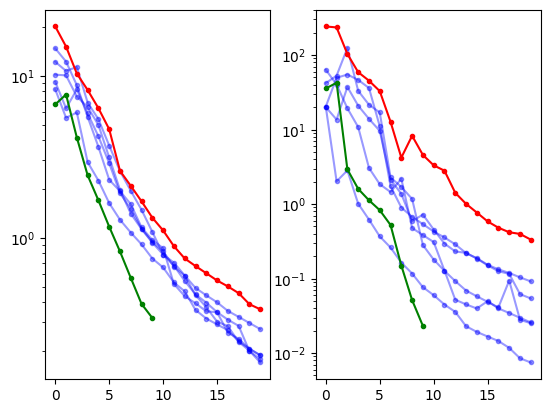

In [31]:
%matplotlib inline
fig, axs = plt.subplots(ncols=2)
for i in range(5):
    imse = np.array(result_dictionary[f"MC_{i}"]["logs"]["imse"])
    imse = imse[~np.isnan(imse)]
    imse_del = np.array(result_dictionary[f"MC_{i}"]["logs"]["imse_del"])
    imse_del = imse_del[~np.isnan(imse_del)]
    axs[0].plot(imse, '.-', label="imse", color="b", alpha=0.4)
    axs[1].plot(imse_del, '.-', label="imse del", color="b", alpha=0.4)
imse = np.array(result_dictionary["halton"]["logs"]["imse"])
imse = imse[~np.isnan(imse)]
imse_del = np.array(result_dictionary["halton"]["logs"]["imse_del"])
imse_del = imse_del[~np.isnan(imse_del)]
axs[0].plot(imse, '.-', color="r")
axs[1].plot(imse_del, '.-', color="r")

imse = np.array(result_dictionary["maxvar"]["logs"]["imse"])
imse = imse[~np.isnan(imse)]
imse_del = np.array(result_dictionary["maxvar"]["logs"]["imse_del"])
imse_del = imse_del[~np.isnan(imse_del)]
axs[0].plot(imse, '.-', color="g")
axs[1].plot(imse_del, '.-', color="g")
for ax in axs:
    ax.set_yscale("log")
plt.show()